# confidential interval of AR model

今回はARモデルを例に時系列モデルの信頼区間について考える。

このノートは[経済・ファイナンスデータの軽量時系列分析](http://www.asakura.co.jp/books/isbn/978-4-254-12792-8/)を勉強しながら書いたものなので、数式などの詳細はそちらを読むこと。

In [2]:
import numpy as np
import matplotlib.pyplot as plt

今回使うパラメータの説明
- N: データの観測点数
- h: 予測したい点の数
- M: 予測/サンプリングする系統数
- p: AR(p)のp

## データの生成。

今回はp=1とする。

つまり、$y_{t+1} = c + \phi y_t + \epsilon$

(0.0, 12.0)

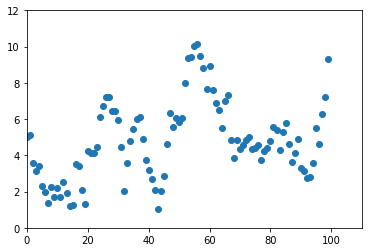

In [219]:
np.random.seed(16)
def y_next(y_t):
    return 0.5+ 0.9 * y_t + np.random.normal(loc=0, scale=1, size=1)

p=1
N = 100
observed = np.zeros(N)
observed[0] = 0.5 / (1- 0.9)
#observed[1] = observed[0] + np.random.normal(loc=0, scale=1, size=1)
for i in range(p, N):
    observed[i] = y_next(observed[i-1])#, observed[i-2])
plt.scatter(range(N), observed)
plt.xlim(0, 110)
plt.ylim(0, 12)

## モデルの推定

モデルの推定には最小二乗法を用いたが、最尤推定でもなんでもいい。

In [220]:
mean = observed.mean()
phi = np.sum((observed - mean)[1:] * (observed - mean)[:-1]) / np.sum((observed - mean)[:-1] ** 2)
c = mean - phi * observed[:-1].mean()

In [221]:
phi

0.9083593539321086

In [222]:
c

0.4821382670070955

## 予測誤差

1期先の予測の平均は$y_{t+1} = c + \phi * y_{t}$で与えられる。
見ればわかるとおりだが、どんな初期値で始まっても平均に回帰していく特性がある。

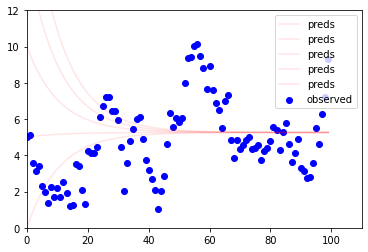

In [223]:
def pred(y_t1, phi, c):
    return c + phi * y_t1

N = 100
M = 5
preds = np.zeros(N * M).reshape(M, N)
preds[0, 0] = observed[0]
preds[1, 0] = 0
preds[2, 0] = 10
preds[3, 0] = 15
preds[4, 0] = 20
for i in range(1, N):
    preds[:, i] = pred(preds[:, i-1], phi, c)
plt.scatter(range(N), observed, color="blue", label="observed")
plt.plot(np.arange(N), preds.T, color="red", label="preds", alpha=0.1)
plt.xlim(0, 110)
plt.ylim(0, 12)
plt.legend()

## h期最適予測
h期先の予測は最も近い点のみの影響しか受けないので、最終的にこんな感じの式になる。

$y_{t+h|t} = \frac{(1-\phi^h)c}{1-\phi} + \phi^hy_t$

(0.0, 12.0)

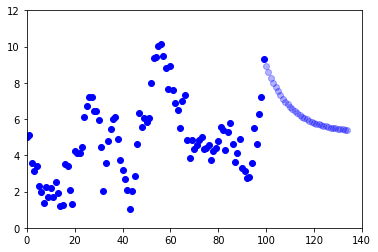

In [224]:
def pred_next_h(y_t, phi, c, h):
    hs = np.arange(1, h+1)
    return ((1-np.power(phi, hs)) * c )/ (1-phi) + np.power(phi, hs) * y_t

h = 35
plt.scatter(range(N), observed, color="blue", label="observed")
preds_h = pred_next_h(observed[-1], phi, c, h)
plt.scatter(range(N, N+h), preds_h, color="blue", alpha=0.3)
plt.xlim(0, 140)
plt.ylim(0, 12)

ということで、AR仮定の予測は遠くなれば遠くなるほど観測値の影響が減衰し、最終的には平均値に収束する。

しかし、実際に取りうる値は確率的である。こんな感じ。

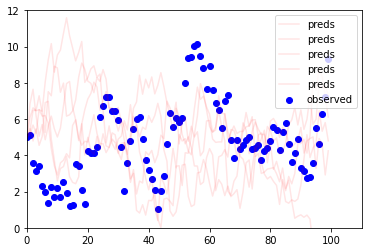

In [225]:
def pred_with_noise(y_t1, phi, c):
    return c + phi * y_t1 + np.random.normal(loc=0, scale=1, size=y_t1.shape)

N = 100
M = 5
preds = np.zeros(N * M).reshape(M, N)
preds[:, 0] = observed[0]
for i in range(1, N):
    preds[:, i] = pred_with_noise(preds[:, i-1], phi, c)
plt.scatter(range(N), observed, color="blue", label="observed")
plt.plot(np.arange(N), preds.T, color="red", label="preds", alpha=0.1)
plt.xlim(0, 110)
plt.ylim(0, 12)
plt.legend()

もちろん平均は$\frac{c}{1-\phi}$付近になる。

In [226]:
print("mu: ", c / (1-phi))
print("preds mean:", preds.mean())

mu:  5.261183630786569
preds mean: 4.859091062481719


## 区間推定

確率的なモデルであるため、信頼区間を含めて計算する。
今回の場合はp=1なので、1つ前のデータを所与にして、いまのデータを予測し、その範囲を計算する必要がある。

観測値があるところは実際の値を使って行う。

観測値がない完全に予測しないといけない区間は、1点ずつ予測していく。(つまりここから分かる通り、誤差が蓄積していく）

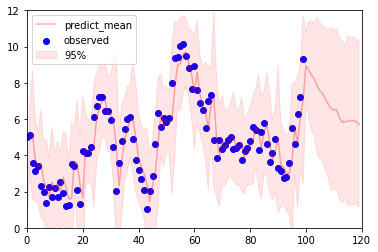

In [227]:
N = 100
h = 20
M = 100

MSEs = np.zeros(N+h)

percentile = np.zeros((N+h) * 3).reshape((N+h), 3)

# 観測データがあるうちは直前の点から推定する
mean =  pred(observed, phi, c)[:-1]
samples = mean + np.random.normal(loc=0, scale=1, size=(M, N-1))
MSEs[:N-1] = np.sum((samples-observed[1:]) ** 2, axis=0) / N
percentile[1:N, 0] = mean - 1.96 * np.sqrt(MSEs[:N-1])
percentile[1:N, 1] = mean 
percentile[1:N, 2] = mean+ 1.96 * np.sqrt(MSEs[:N-1])

# 完全に予測のときは予測の1つ前の点から次の点を予測していく
predicted_samples = np.zeros((M, (h+1)))
predicted_samples[:, 0] = observed[-1]
for i in range(1, h+1):
    predicted_samples[:, i] = c + phi * predicted_samples[:, i-1] + np.random.normal(loc=0, scale=1, size=(M))
predicted_samples = predicted_samples[:, 1:]

predicted_mean = predicted_samples.mean(axis=0)
MSEs[N:] = np.sum((predicted_samples-predicted_mean) ** 2, axis=0) / M

percentile[N:, 0] = predicted_mean - 1.96 * np.sqrt(MSEs[N:])
percentile[N:, 1] = predicted_mean 
percentile[N:, 2] = predicted_mean+ 1.96 * np.sqrt(MSEs[N:])

# 描画
plt.scatter(range(N), observed, color="blue", label="observed")
plt.fill_between(np.arange((N+h)), percentile[:, 0], percentile[:, 2], color="red", label="95%", alpha=0.1)
plt.plot(np.arange(1, (N+h)), percentile[1:, 1],color="red", alpha=0.3, label="predict_mean")

plt.xlim(0, 120)
plt.ylim(0, 12)
plt.legend()

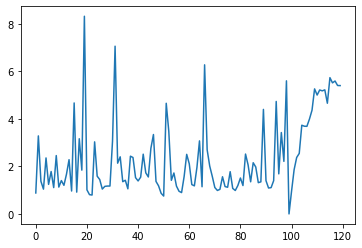

In [228]:
plt.plot(np.arange(0, (N+h)), MSEs)